By <br>
Marco Føhns-Greve (Studie nr. 60997) <br>
Mads Zeuch Ethelberg (Studie nr. 62608) <br>

# Business Case - KBA Slagelse blood tests
The business case is based on real data from the department of clinical biochemistry at the hospital in Slagelse (KBA Slagelse) where Mads E. is employed. Every year KBA is asked to reduce cost and need to show possible options to the directors, but in recent times the amount of work has become more and more unbalanced with the number of employees to perform the work. This unbalance between the amount of work and number of employees has led to poor performance and quality of the department in general which have risen the interest to make drastic changes. <br>

This notebook is aimed to explorer possible ways to reduce the cost to free up resources or to satisfy the ongoing cost reduction demands or to reduce the workload on the employees. The dataset used is provided by KBA Slagelse consisting of series of tests that have been recorded from the 1st of January 2018 to the 30th of September 2020 and is limited to records from the "Akut stue", "Akut 1.sal" and "Hjerte" departments. Any personal data like CPR numbers have been converted to fictive unrelated IDs to enable grouping of unique patients and still keep each patient anonymous.

## Description of dataset attributes
<br> <B>The blood sample datasets</B>
<ul>
<li> Beh.status   : The status if the rekvisition is finalized or in progress. </li>
<li> Rekvirent    : The ID of the departments requesting tests.</li>
<li> Rekv.navn    : The name of the departments requesting tests.</li>
<li> Rkv.nr.      : The ID of the different rekvisitions, like an order ID. Consist of 12 digits but has been anonymized in outputs. </li>
<li> Kvnt.nr.     : The ID of the different tests.</li>
<li> Prvt.dato    : The date of the sample in format DD.MM.YYYY.</li>
<li> Laboratorium : The laboratory providing the results for a given test.</li>
<li> PMB.nr.      : The ID numbers for the samples. Consist of 12 digits but has been anonymized in outputs.</li>
<li> Resultat     : The results of the tests.</li>
<li> Kvnt.navn    : The name of the different tests.</li>
<li> Prvt.stedgeo : Which scenario the samples have been drawn.</li>
<li> Res.producent: The laboratory providing the results for a given test.</li>
<li> Prvt.kl      : The time of the sample 24hour format HH.MM.</li>
<li> fiktivId     : The fictitious IDs based on CPR numbers used to group "Rkv.nr." to unique anonymous patients.</li>
</ul> 

<br> <B>The pricelist dataset</B>
<ul>
<li> Navn      : The name of the different tests.</li>
<li> BCC.nr.   : The ID of the different tests, equal to "Kvnt.nr." in the first dataset.</li>
<li> NPU.kode  : The ID of the different tests but used for an other system.</li>
<li> Lokal.kode: An old ID of the different tests which are being phased out in favour of the NUP.kode.</li>
<li> Pris      : Contains the price in DKK of the different tests available, based on an internal source called LMV prices.</li>
<li> X         : Leftover from Excel containing only notes, should be ignored.</li>
<li> X.1       : Leftover from Excel containing only notes, should be ignored.</li>
<li> X.2       : Leftover from Excel containing only notes, should be ignored.</li>
<li> X.3       : Leftover from Excel containing only notes, should be ignored.</li>
</ul> 
 


# Loading libraries and the datasets

First, we have to load in the libraries that are used in this notebook, and lastly load in the datasets we need to work with. To easily make the coding environment accessible, the packages that do not come default installed with Jupyter R, have been included in an out-commented form which will be needed to run at least once to make sure the proper packages are available. 

In [1]:
### install missing packages, should only run one time.
# install.packages("tidyverse")
# install.packages("forecast")

Next, a function is defined to load a list of packages in a suppressed way, to remove messages and warnings while loading the libraries. Afterward, a list of packages is listed and the function is called with the list. This will load the libraries to be used in the rest of the notebook.

In [2]:
load <- function(packages) {
   for (package in packages){ 
        suppressWarnings( suppressMessages(
                library(package, character.only = TRUE)
        )  )
   }}

In [3]:
# List of packages to load
packages <- c(
     "tidyverse"   # all-around packages for datahandling
    ,"magrittr"    # a package to extend the piping operations to include operations like %<>%
    ,"lubridate"   # a package to easily clean date and time types and formats
    ,"tidyr"
    ,"forecast"    # a package to make forecast on timeseries
)
load(packages)

Now the datasets need to be loaded. First, a dataset for each year is loaded which makes up the bulk of the data and covers which tests have been ordered and the status of each "order". Secondly, the dataset priser.csv is loaded that contains prices for most of the available tests which enable us to estimate cost in the notebook.

In [4]:
# load data from 2018, 2019 and 2020
rawdata <- read.table(file = "AkutHa2018.csv", sep = ";", header=TRUE) %>%
rbind(read.table(file = "AkutHa2019.csv", sep = ";", header=TRUE)) %>%
rbind(read.table(file = "AkutHa2020.csv", sep = ";", header=TRUE))

In [5]:
# load pricelist
pricelist <- read.table(file = "priser.csv", sep = ";", header=TRUE)

## Cleaning the datasets

Next, we need to take a look at the datasets in the current state and clean it before it will be used. First off we will work with the blood test dataset stored in the variable "rawdata", after cleaning that dataset we will move on to cleaning the dataset stored in the pricelist variable.

### Cleaning the rawdata

First, we check if the rawdata has any NA-values and afterward we will take a look at the structure and summarizing statistics of the rawdata.

In [6]:
# checking for NA-values
table(is.na(rawdata))


   FALSE 
36033564 

In [7]:
str(rawdata)

'data.frame':	2573826 obs. of  14 variables:
 $ Beh.status   : Factor w/ 3 levels "Afslut","Ejsvar",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Rekvirent    : Factor w/ 4 levels "slakaiha","slaaki1",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ Rekv.navn    : Factor w/ 4 levels "RSJ, Akut Afd.1.Sal, Sengeafs., SLA",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Rkv.nr.      : num  1.05e+11 1.05e+11 1.05e+11 1.05e+11 1.05e+11 ...
 $ Kvnt.nr.     : Factor w/ 757 levels "100033","100034",..: 245 197 485 394 388 193 114 309 188 67 ...
 $ Prvt.dato    : Factor w/ 1004 levels "01-01-2018","01-02-2018",..: 190 190 190 190 190 190 190 190 190 190 ...
 $ Laboratorium : Factor w/ 1 level "SLAKBD": 1 1 1 1 1 1 1 1 1 1 ...
 $ PMB.nr.      : num  1.05e+11 1.05e+11 1.05e+11 1.05e+11 1.05e+11 ...
 $ Resultat     : Factor w/ 8318 levels "","----","*",..: 5851 5851 5851 5851 5851 1816 852 5099 3018 1444 ...
 $ Kvnt.navn    : Factor w/ 786 levels ""," 25-OH-Vitamin D(D3+D2);P",..: 271 40 339 418 299 358 315 67 34 79 ...
 $ Prvt.stedgeo : Factor w

In [8]:
summary(rawdata)

  Beh.status         Rekvirent      
 Afslut:2552121   slakaiha: 280919  
 Ejsvar:  21664   slaaki1 :1250461  
 Svar  :     41   slaaki2 : 932735  
                  SLAKAI  : 109711  
                                    
                                    
                                    
                                Rekv.navn          Rkv.nr.         
 RSJ, Akut Afd.1.Sal, Sengeafs., SLA : 932735   Min.   :1.000e+11  
 RSJ, Akut Afd.stuen, Sengeafs., SLA :1250461   1st Qu.:1.049e+11  
 RSJ, Kardiologisk sengeafs., HA, SLA: 280919   Median :1.050e+11  
 RSJ, Kardiologisk Sengeafs., SLA    : 109711   Mean   :1.053e+11  
                                                3rd Qu.:1.057e+11  
                                                Max.   :1.064e+11  
                                                                   
    Kvnt.nr.            Prvt.dato       Laboratorium        PMB.nr.         
 3230   : 123290   30-07-2018:   4273   SLAKBD:2573826   Min.   :1.000e+11  
 4998 

While taking a look at the output above some places to do cleaning can be identified. "Prvt.dato" and "Prvt.kl" are stored as factors and can be combined into a time type. Then the columns "Laboratorium", "Rekv.navn" and "Beh.status" can be dropped since "Laboratorium" only have 1 value saying it was KBA Slagelse doing the test. "Rekv.navn" and "Beh.status" are redundant information that only adds to the complexity of cleaning the dataset. For "Rekv.navn" the redundancy comes from "Rekvirent", and for "Beh.status" it comes from "Resultat" with the value of "Aflyst". To improve readability of the "Rekvirent", factors will be renamed to more explicit state the names of the departments. <br>

Looking at the "Prvt.stedgeo" it is clear there are some casing issues and looking at the "Resultat" it can be noticed that the danish "," is used as the decimal separator instead of ".". Further undocumented studies of the data have shown that some mistakes in character encoding have happened. To clean these mistakes each column is cased to lower case, and identified strings with encoding mistakes are replaced, then cast to lowercase again to avoid any coding errors with casing and lastly stored as factors. <br>

Lastly, it shall be noted that "Rkv.nr." and "PMB.nr." is stored as factors and not numeric since it is an ID and not a numeric value that calculations should be performed upon.

In [9]:
# combining date and time, and casting to a time object by the dmy_hm() lubridate function
rawdata$Dato.og.Tid <- dmy_hm(paste(rawdata$Prvt.dato, rawdata$Prvt.kl))
rawdata %<>% select(-Prvt.kl, -Prvt.dato)

In [10]:
# dropping columns that have minor to no use
rawdata %<>% select(-Laboratorium, -Rekv.navn, -Beh.status)

In [11]:
# fix mistake in character encoding, casting and stores as factors
pat = c(
    "taget i nåstved" = "Taget i Næstved",
    "tages p† runde" = "tages på runde"
)

rawdata$Prvt.stedgeo %<>% tolower() %>% str_replace_all(pattern = pat) %>% tolower() %>% as.factor()

In [12]:
# fix mistake in character encoding, casting and stores as factors
pat = c(
    "håmo" = "Hæmo"
)

rawdata$Kvnt.navn %<>% tolower() %>% str_replace_all(pattern = pat) %>% tolower() %>% as.factor()

In [13]:
# fix mistake in character encoding, casting and stores as factors
pat = c(
    "n‘stved" = "næstved",
    "nyk›bing" = "nykøbing",
    "holb‘k" = "holbæk",
    "k›ge" = "køge"
)

rawdata$Res.producent %<>% tolower() %>% str_replace_all(pattern = pat) %>% tolower() %>% as.factor()

In [14]:
# Translate department codes to proper readable names
pat = c(
    "slakaiha" = "Hjerte Afdeling",
    "slakai" = "Hjerte Afdeling",
    "slaaki1" = "Akut Stue",
    "slaaki2" = "Akut 1.Sal"
)

rawdata$Rekvirent %<>% tolower() %>% str_replace_all(pattern = pat) %>% as.factor()

In [15]:
# fix mistake in character encoding, casting and stores as factors
pat = c(
   "ikke udf›rt" = "ikke udført",
    "," = "."
)

rawdata$Resultat %<>% tolower() %>% str_replace_all(pattern = pat) %>% as.factor()

In [16]:
# casting to factor type
rawdata$Rkv.nr. %<>% as.factor()
rawdata$PMB.nr. %<>% as.factor()

To validate that the cleaning has worked we will take a look at the resulting structure and summarizing statistics of the cleaned rawdata which can be seen below. Taking the earlier concerns into account it can be seen that the dataset looks a lot cleaner. The number of Rekvirents has dropped from 4 to 3, there are no longer casing problems in the "Prvt.stedgeo" column and the Resultat column has the proper decimal separator. <br>

To make the dataset a little more useful we will drop entries that have been cancelled, not performed, or in some way did not reach the laboratory.

In [17]:
rawdata %>%
mutate(Rkv.nr. = "anonymize") %>% # anonymize Rkv.nr for output, is processed as factors
mutate(PMB.nr. = "anonymize") %>% # anonymize PMB.nr for output, is processed as factors
str()

'data.frame':	2573826 obs. of  10 variables:
 $ Rekvirent    : Factor w/ 3 levels "Akut 1.Sal","Akut Stue",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Rkv.nr.      : chr  "anonymize" "anonymize" "anonymize" "anonymize" ...
 $ Kvnt.nr.     : Factor w/ 757 levels "100033","100034",..: 245 197 485 394 388 193 114 309 188 67 ...
 $ PMB.nr.      : chr  "anonymize" "anonymize" "anonymize" "anonymize" ...
 $ Resultat     : Factor w/ 8301 levels "","----","*",..: 8196 8196 8196 8196 8196 2290 969 7135 4151 1752 ...
 $ Kvnt.navn    : Factor w/ 786 levels ""," 25-oh-vitamin d(d3+d2);p",..: 358 50 460 563 406 482 426 93 44 110 ...
 $ Prvt.stedgeo : Factor w/ 12 levels "poctsvar","send til webhotel",..: 8 8 8 8 8 8 8 8 8 8 ...
 $ Res.producent: Factor w/ 28 levels "","2,39671e+14",..: 24 24 24 24 24 24 24 24 24 24 ...
 $ fiktivId     : Factor w/ 43709 levels "ID00001","ID00002",..: 8348 8348 8348 8348 8348 15375 15375 15375 15375 15375 ...
 $ Dato.og.Tid  : POSIXct, format: "2018-10-16 00:00:00" "2018-10-16 00

In [18]:
rawdata %>%
mutate(Rkv.nr. = "anonymize") %>% # anonymize Rkv.nr for output, is processed as factors
mutate(PMB.nr. = "anonymize") %>% # anonymize PMB.nr for output, is processed as factors
summary()

           Rekvirent         Rkv.nr.             Kvnt.nr.      
 Akut 1.Sal     : 932735   Length:2573826     3230   : 123290  
 Akut Stue      :1250461   Class :character   4998   : 122063  
 Hjerte Afdeling: 390630   Mode  :character   3429   : 121928  
                                              2319   : 115535  
                                              2593   : 114067  
                                              19748  : 113400  
                                              (Other):1863543  
   PMB.nr.             Resultat                            Kvnt.navn      
 Length:2573826     0      : 141794   kalium;p                  : 123290  
 Class :character   aflyst : 131568   kreatinin;p               : 122062  
 Mode  :character   tek15* :  81514   natrium;p                 : 121928  
                    0.1    :  64945   leukocytter;b             : 114067  
                    >90    :  37884   c-reaktivt protein [crp];p: 113399  
                    1      :  36994   

In [19]:
# Dropping cancelled tests
rawdata %<>%
filter(Resultat != "aflyst" &
       Resultat != "ikke taget" &
       Resultat != "dublet" &
       Resultat != "ej modtaget" &
       Resultat != "afbestilt" & 
       Resultat != "ej tilstede" &
       Resultat != "ikke udført"
)


### Cleaning the pricelist

Now it is time to look into the pricelist dataset. We will first look into how the structure and summarizing statistics of the dataset is.

In [20]:
head(pricelist,1)

Navn,BCC.nr.,NPU.kode,Lokal.kode,Pris,X,X.1,X.2,X.3
17-Hydroxyprogesteron (0 min);P,4977,NPU04977,,135,NA,,,NA


In [21]:
str(pricelist)

'data.frame':	1249 obs. of  9 variables:
 $ Navn      : Factor w/ 694 levels "","17-Hydroxyprogesteron (0 min);P",..: 2 3 4 5 6 7 8 10 11 14 ...
 $ BCC.nr.   : int  4977 4978 21623 2460 1435 10267 2424 18242 18243 10504 ...
 $ NPU.kode  : Factor w/ 682 levels "","DNK05219",..: 143 144 541 63 20 171 62 450 451 177 ...
 $ Lokal.kode: Factor w/ 29 levels "","EPC00001",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Pris      : int  135 135 135 135 203 68 34 63 63 7 ...
 $ X         : int  NA NA NA NA NA NA NA NA NA NA ...
 $ X.1       : Factor w/ 4 levels "","Blodprøvetagning",..: 1 2 2 3 3 4 1 1 1 1 ...
 $ X.2       : Factor w/ 4 levels "","Alle","Ambulant",..: 1 4 3 4 3 2 1 1 1 1 ...
 $ X.3       : int  NA 101 71 176 146 16 NA NA NA NA ...


In [22]:
summary(pricelist)

                               Navn         BCC.nr.          NPU.kode   
                                 : 170   Min.   :   37           : 194  
 Protein;Csv                     :   4   1st Qu.: 4972   DNK05219:   2  
 Urat;Ledv                       :   3   Median :13298   DNK05221:   2  
 17-Hydroxyprogesteron (0 min);P :   2   Mean   :17108   DNK35307:   2  
 17-Hydroxyprogesteron (30 min);P:   2   3rd Qu.:19961   DNK35834:   2  
 17-Hydroxyprogesteron (60 min);P:   2   Max.   :59084   DNK35842:   2  
 (Other)                         :1066   NA's   :170     (Other) :1045  
    Lokal.kode        Pris               X                      X.1      
         :1194   Min.   :   4.00   Min.   :101                    :1244  
 EPC00001:   2   1st Qu.:  20.75   1st Qu.:101    Blodprøvetagning:   2  
 EPC00002:   2   Median :  80.00   Median :101    EKG tagning     :   2  
 EPC00003:   2   Mean   : 231.79   Mean   :101    Sendeprøver     :   1  
 EPC00004:   2   3rd Qu.: 119.00   3rd Qu.:101

It is clear from the output above that the dataset contains NA-values as can be seen in "BCC.nr." and "Pris", and at the same time, there must be some badly structured cells from the excel spreadsheet source based on the X, X.1, X.2, and X.3 columns. <br>

By applying some business knowledge we know that "Kvnt.nr." from rawdata is equal to the "BCC.nr." in the pricelist dataset, and that "NPU.kode" is used when working with Sundhedsplatformen (SP) which in our cases "NPU.kode" can be dropped. <br>

To clean the dataset we will first drop any entries that have an NA-value in the "Pris" column, only keep unique values of "BCC.nr." and only keep the "Navn", "BCC.nr.", and "Pris" columns since it is those attributes we are interested in. Lastly, we check if we have any NA-values and how the structure and summarizing statistics of the dataset looks.

In [23]:
pricelist %<>%
drop_na(Pris) %>%
distinct(BCC.nr., .keep_all= TRUE) %>%
select(Navn, BCC.nr., Pris)

In [24]:
table(is.na(pricelist))


FALSE 
 2091 

In [25]:
head(pricelist,1)

Navn,BCC.nr.,Pris
17-Hydroxyprogesteron (0 min);P,4977,135


In [26]:
str(pricelist)

'data.frame':	697 obs. of  3 variables:
 $ Navn   : Factor w/ 694 levels "","17-Hydroxyprogesteron (0 min);P",..: 2 3 4 5 6 7 8 10 11 14 ...
 $ BCC.nr.: int  4977 4978 21623 2460 1435 10267 2424 18242 18243 10504 ...
 $ Pris   : int  135 135 135 135 203 68 34 63 63 7 ...


In [27]:
summary(pricelist)

                               Navn        BCC.nr.           Pris     
 APOB-gen;DNA                    :  2   Min.   :   37   Min.   :   4  
 Protein;Csv                     :  2   1st Qu.:10216   1st Qu.:  41  
 Protein;U                       :  2   Median :13280   Median :  80  
 Urat;Ledv                       :  2   Mean   :17331   Mean   : 280  
 17-Hydroxyprogesteron (0 min);P :  1   3rd Qu.:19926   3rd Qu.: 119  
 17-Hydroxyprogesteron (30 min);P:  1   Max.   :59084   Max.   :5500  
 (Other)                         :687                                 

Now the datasets have been roughly cleaned to make a solid base to start exploring the datasets. Next, we will work with some questions to explorer the dataset and gain knowledge about the dataset.

# Explorative data analysis

In the data analysis, we will first look into the frequency and cost of the different tests performed at KBA. Afterward, the EKG and INR tests are analyzed further as a result of the frequency and cost analysis which shows these two tests to be significantly interesting. Lastly, the number of RKV is analyzed and a model to try and predict the near future is applied to the dataset. 

## Analysis of frequency and cost of tests

To get started with the data analysis we want to know if we can assume that staff from KBA Slagelse are the ones to draw the samples or if the dataset is including samples taken by staff from other departments too. 

<B>Question:</B> Is KBA Slagelse the only ones to draw samples or are other departments included in the dataset?

One possible way to answer this question will be to look at the "Prvt.stedgeo" column which describes under which scenario the samples have been drawn. Values of "tages på runde" and "tagets nu" are given to samples drawn by KBA staff and a value of "taget af afdeling" is given to samples drawn by the given department itself.

In [28]:
rawdata %>%
distinct(Rkv.nr., .keep_all= TRUE) %>%
mutate(year = year(Dato.og.Tid)) %>%
group_by(Prvt.stedgeo, year) %>%
tally(name = "antal") %>%                 # count per year
group_by(Prvt.stedgeo) %>%
add_tally(antal, name = "Total") %>%      # count total
spread(year, antal, fill = 0) %>%         # spread year columnn into a column for each year
relocate(Total, .after = last_col()) %>%  # move the Total column to the right
arrange(desc(Total))

Prvt.stedgeo,2018,2019,2020,Total
tages på runde,62452,68740,49106,180298
tages nu,22491,22175,14956,59622
tages af afdeling,1904,2723,1788,6415
tages i kba amb,231,284,194,709
tages i ringsted,26,76,52,154
poctsvar,31,45,7,83
tilsendt,2,2,12,16
tages i korsør,4,0,0,4
send til webhotel,0,3,0,3
taget i næstved,0,2,0,2


<B>Conclusion:</B> In the table above it can be seen that most of the samples drawn are done by the KBA staff. Some samples are drawn by other departments but a deep look into those samples shows that it is mostly urine samples which are a minority of the tests performed by KBA Slagelse. By the knowledge of the business, some samples that should have been marked as "tages af afdeling" are wrongfully marked as "tages nu" by human error while ordering the samples. We have assessed that this error will have minor to no influence on the results since it will mostly affect the number of urine samples and have very little influence on the much larger number of blood samples that are more interesting in this notebook. We will then assume that mostly all of the blood samples are drawn by the KBA Slagelse staff.

Now that we know who is drawing the samples we would like to focus on the available tests. This is to give an idea about which tests are the most frequent, how is the distribution of the budget over these tests, and if there are any differences between the years. 

<B>Question:</B> Which tests are the most frequent?

To answer this question we count how many entries of each test name (Kvnt.navn) that are in the dataset, first per year and afterward in total. The result is then stored in the variable testFrequency where each test name has a column for each year and a column for the total. The order is arranged by the total column. <br>
It should be noted that only the 10 most frequent tests are in the output table, and the 30 most frequent tests are in the output graph below, but all available tests are still stored in the testFrequency variable. 

In [29]:
rawdata %>%
mutate(year = year(Dato.og.Tid)) %>%
group_by(Kvnt.navn, year) %>%
tally(name = "antal") %>%                 # count per year
group_by(Kvnt.navn) %>%
add_tally(antal, name = "Total") %>%      # count total
spread(year, antal, fill = 0) %>%         # spread year columnn into a column for each year
relocate(Total, .after = last_col()) %>%  # move the Total column to the right
arrange(desc(Total)) -> testFrequency
head(testFrequency, 10)

Kvnt.navn,2018,2019,2020,Total
kalium;p,41053,44133,31877,117063
kreatinin;p,40674,43797,31528,115999
natrium;p,40622,43707,31496,115825
leukocytter;b,38065,40937,29239,108241
c-reaktivt protein [crp];p,37811,40746,29181,107738
"egfr / 1,73m²(ckd-epi); nyre",29389,42375,30542,102306
hæmoglobin;b,28259,41333,29545,99137
albumin;p,33122,36387,25952,95461
trombocytter;b,31210,33797,23805,88812
elektrokardiografi [ekg12];pt,28675,31356,21431,81462


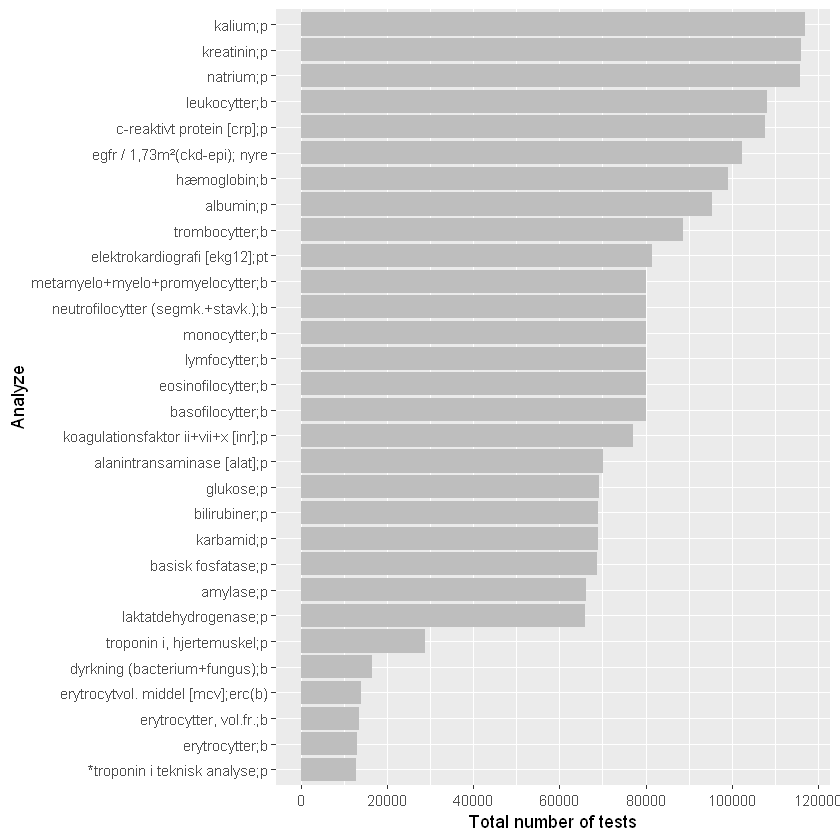

In [30]:
ggplot(data = head(testFrequency, 30), aes(x = reorder(Kvnt.navn, Total), y = Total)) + 
geom_col(fill= 'grey') + 

coord_flip() +
labs(x = "Analyze", y = "Total number of tests") +       # set titels on x and y axis
scale_y_continuous(breaks = seq(0, 120000, 20000))       # set scale of the y axis

<B>Conclusion:</B> By looking at the table it can be noted that the number of tests is in general increasing from 2018 to 2019. Looking at 2020 it is important to remember the dataset stop at "2020-09-30" which will mean that only 9 out of the 12 months are included in the dataset. More importantly, both the graph and table shows that tests from the most frequent test groups are present like the electrolytes (Kalium, Natrium, kreatinin, albumin, and hæmoglobin) and the infection numbers (C-reaktivt protein [CRP] and Leukocytter) which compared with the knowledge about the business is to be expected.

Let's see if anything changes if we take the cost of the different tests into account while still looking at the frequency of each test. This is mostly to get an idea about the weight each test has in KBA's budget.

<B>Question:</B> How much money is spent on each test, and which ones are the most costly.

In [31]:
rawdata %>%
mutate(year = year(Dato.og.Tid)) %>%
group_by(Kvnt.nr., year) %>%
tally(name = "antal") %>% # count how many of each Kvnt.nr. for a given year
group_by(Kvnt.nr.) %>%
add_tally(antal, name = "Total") %>% # count how many Kvnt.nr across all years
merge(y = pricelist, by.x = "Kvnt.nr.", by.y = "BCC.nr.") %>% # add a list of prices for calculations
mutate(pr.Year = antal * Pris) %>%
mutate(Total = Total * Pris) %>%
arrange(desc(Total)) -> Udgift # a table which has rows for each unique combination of Kvnt.nr. and year

# split the year column into a column for 2018, 2019, 2020
Udgift %>%
select(-antal) %>%
spread(year, pr.Year, fill = 0) %>%
relocate(Total, .after = last_col()) %>%  # move the Total column to the right
arrange(desc(Total)) -> UdgiftTabel # a table which has rows for each unique Kvnt.nr.

# shows the resulting table
head(UdgiftTabel, 5)

Kvnt.nr.,Navn,Pris,2018,2019,2020,Total
5219,Elektrokardiografi [EKG12];Pt,101,2896175,3166956,2164531,8227662
1685,Koagulationsfaktor II+VII+X [INR];P,41,1110895,1199783,850340,3161018
3230,Kalium;P,14,574742,617862,446278,1638882
4998,Kreatinin;P,14,569436,613172,441392,1624000
3429,Natrium;P,14,568708,611898,440944,1621550


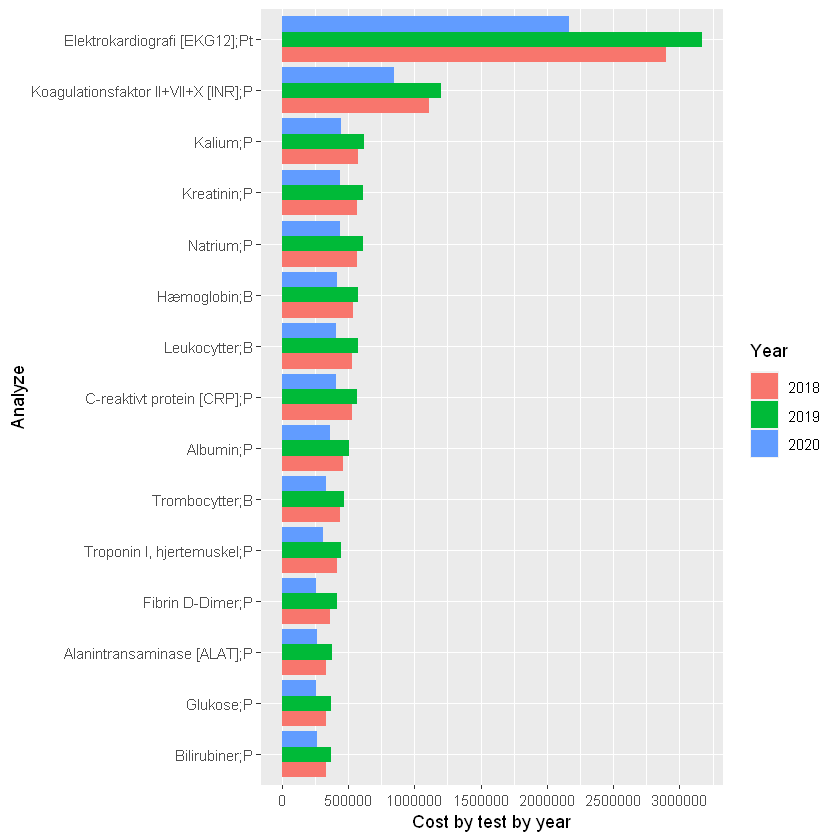

In [32]:
ggplot(data = head(Udgift,3*15)) + 
geom_col(mapping = 
         aes(x = reorder(Navn, pr.Year), # reorder is sorting navn based on the value of pr.Year
         y = pr.Year,                    # puts price pr year as the y-axis
         fill = as.factor(year)),        # make multiple bars for each Analyzes(Navn) bases on the year
         position = "dodge") +           # arrange the multiple bars next to each other (else they would be stacked)

labs(x = "Analyze", y = "Cost by test by year") +         # set titels on x and y axis
scale_fill_discrete(name="Year") +                        # set legends title
coord_flip() +                                            # flip x and y axis to make the barplot tall insted of width
scale_y_continuous(breaks = seq(0, 3000000, 500000))      # set scale of the y axis

<B>Conclusion:</B> Both the table and graph above shows that Elektrokardiografi (EKG) is by far the most costly test to perform, and secondly Koagulationsfaktor II+VII+X (INR). Compared to the most frequent test of kalium, INR costs 2 times as much and EKG costs 5 times as much. By having insight into the business it was expected to see EKG being a costly test to perform, but it is surprising how costly it is. The cost of INR was a big surprise and to the general staff of KBA it comes as a surprise too. 

After recovering from the surprise, we knew we would have to explorer the dataset further with a focus on EKG and INR to get a deeper understanding.

## Analysis of the EKG test

To get a better understanding of the EKG test, we would like to know how much a single EKG cost and how many EKGs the different departments are ordering.

<b>Question:</b> How much does a single EKG cost?

In [33]:
pricelist %>%
filter(BCC.nr. == 5219) -> ekgPrice
ekgPrice                   # show name, bcc nr and price
ekgPrice <- ekgPrice$Pris  # store only the price

Navn,BCC.nr.,Pris
Elektrokardiografi [EKG12];Pt,5219,101


<b>Conclusion:</b> The price of a single EKG is estimated to cost 101 DKK based on the pricelist dataset

Next, we would like to know who is ordering the EKGs.

<b>Question:</b> How is the distribution of ordered EKGs by departments

In [34]:
rawdata %>%
filter(Kvnt.nr. == 5219 & (Resultat != "Aflyst" | Resultat != "aflyst")) %>%
mutate(year = year(Dato.og.Tid)) %>%
group_by(Rekvirent, year) %>%
tally(name = "antal") %>% # count how many of each Rekvirent for a given year
arrange(Rekvirent) -> EKG # a table which has rows for each unique combination of Rekvirent and year

# split the year column into a column for 2018, 2019, 2020
EKG %>%
spread(year, antal, fill = 0) -> EKGTabel

EKGTabel

Rekvirent,2018,2019,2020
Akut 1.Sal,8147,9990,6382
Akut Stue,13890,14439,10213
Hjerte Afdeling,6638,6927,4836


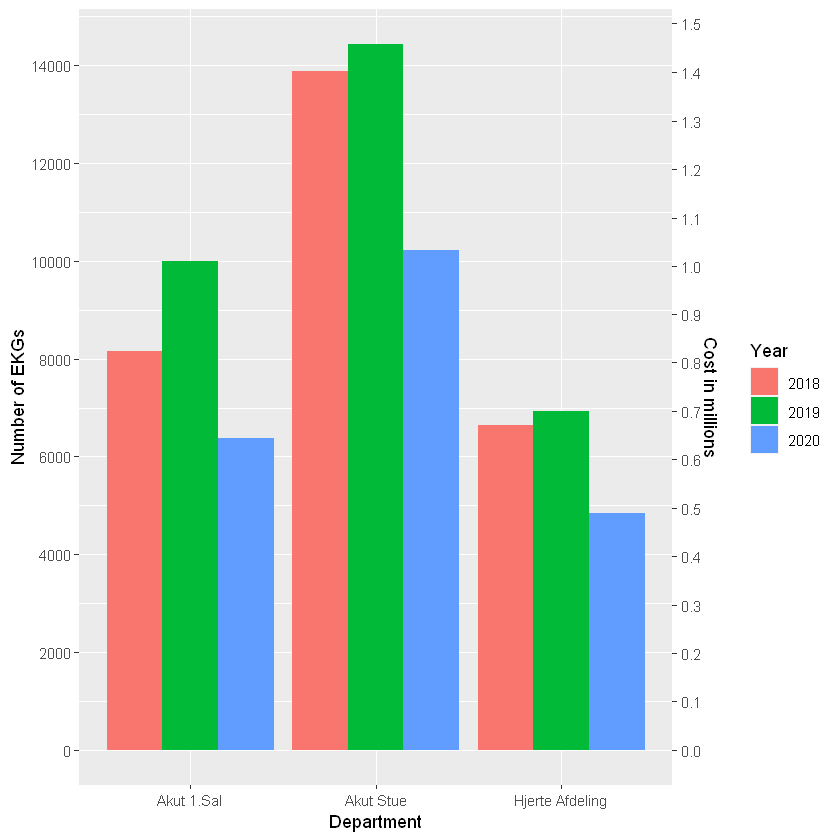

In [35]:
ggplot(data = EKG) + 
geom_col(mapping = 
         aes(x = Rekvirent,         # reorder is sorting navn based on the value of pr.Year
         y = antal,                 # puts price pr year as the y-axis
         fill = as.factor(year)),   # make multiple bars for each Analyzes(Navn) bases on the year
         position = "dodge") +      # arrange the multiple bars next to each other (else they would be stacked)

labs(x = "Department", y = "Number of EKGs") +     # set titels on x and y axis
scale_fill_discrete(name="Year") +                 # set legends title
scale_y_continuous(breaks = seq(0, 16000, 2000),   # set scale of the y axis
                  sec.axis = sec_axis(~ . * ekgPrice /1000000, name = "Cost in millions", breaks = seq(0, 1.500, 0.100000))
                  ) 

It should be noted that the cost in the graph above is calculated directly in the second y-axis, by multiplying the number of EKGs with the discovered cost of 101 DKK.

<b>Conclusion:</b> The table and graph above show that Akut Stue is the department that is ordering the most EKGs followed by Akut 1.Sal. It was expected that Akut 1.Sal would have ordered more EKGs than Akut stue since Akut stue has 13 rooms for patients and Akut 1.Sal has around 35 rooms for patients. This could be explained by the faster turn-around time they operate with at Akut Stue, by the two departments being sister-departments of the more general Akut department, but still an interesting observation. The Hjerte Afdeling (cardio or heart department in English) is ordering a significant number of EKGs especially if we take into account that it is the only department where the staff can perform EKGs on its own.

Base on the knowledge acquired from the analysis of the EKG test we would like to make two suggestions to reduce cost and/or free up resources in the form of less work pressure on the KBA staff. <br> <br>
<B>Suggestion 1:</B> Demand that all EKGs ordered by the Hjerte Afdeling shall be performed by its own staff. This would free up around 675.000 DKK each year for the KBA. <br> <br>
<B>Suggestion 2:</B> Demand that EKGs should be moved outside KBA's scope of work, probably to a sub-group of the hjerte afdeling, who could perform all EKGs. This would free up around 3 million DKK each year for KBA (see table below), which would help on the staffing issues KBA has been facing lately and would enable KBA to lower its budget, but at the cost of relocating the cost of EKGs elsewhere. 

In [36]:
rawdata %>%
filter(Kvnt.nr. == 5219 & (Resultat != "Aflyst" | Resultat != "aflyst")) %>%
mutate(year = year(Dato.og.Tid)) %>%
group_by(year) %>%
tally(name = "antal") %>%
mutate(cost = antal * 101)

year,antal,cost
2018,28675,2896175
2019,31356,3166956
2020,21431,2164531


## Analysis of the INR test

To get a better understanding of the INR test, we would like to know the cost of a single INR test, how the results of the test are distributed if the result is considered inside or outside the normal values.

<B>Question:</B> What does an INR test cost?

In [37]:
pricelist %>%
filter(BCC.nr. == 1685) -> inrPrice
inrPrice                    # show name, bcc nr and price
inrPrice <- inrPrice$Pris   # store only the price

Navn,BCC.nr.,Pris
Koagulationsfaktor II+VII+X [INR];P,1685,41


<B>Conclusion:</B> An single INR test cost 41 DKK based on the pricelist dataset

Next, we look at the distribution of INR results

<B>Question:</B> How are the results of INR distributed, is most of the results around 1.0 ?

Before we can make use of the results of the INR test we will need to clean the Resultat column further, since the results mostly are numeric, it needs to be turned from factors into numeric. Any results that indicate that a given entry has failed will be converted to 0 and any result >7.0 will be converted to 8.0. This conversion is not to enable any kind of numeric analysis but only to enable them to be represented on the graph below.

In [38]:
pat = c(
    "se kommentar" = "0",
    "mislykket" = "0", 
    "hæmolyse" = "0",  
    "koaguleret" = "0", 
    ">7.0"  = "8.0"
)

rawdata %>%
filter(Kvnt.nr. == 1685) -> inr
inr$Resultat %<>% str_replace_all(pattern = pat) %>% as.factor()
inr$Resultat %<>% droplevels() %>% as.character() %>% as.numeric()

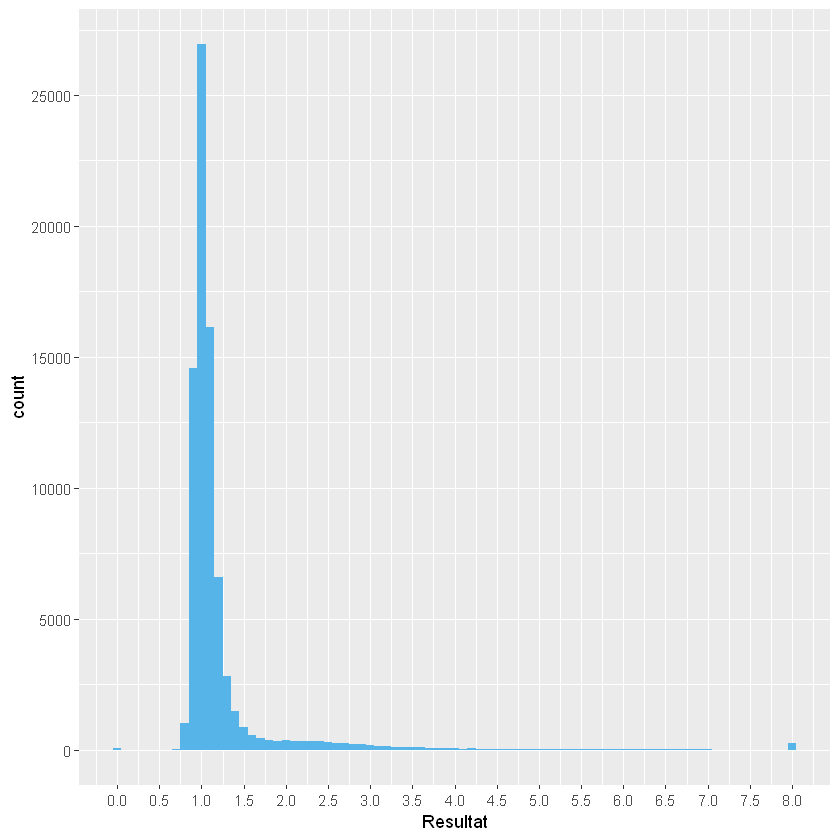

In [39]:
ggplot(inr, aes(Resultat)) +
geom_histogram(binwidth=0.1, stat="bin", fill = "#56B4E9") +
scale_x_continuous(breaks = seq(0, 8, by= 0.5)) +     # set scale of the x axis to seq(from, to, by)
scale_y_continuous(breaks = seq(0, 30000, by= 5000))  # set scale of the y axis

# values at 0 is failed or special cases
# values at 8 is values above 7

Remember that values at 0 are failed or special cases and values at 8.0 is values >7.0

In [40]:
lower_ref = 0.8
upper_ref = 1.2

inr %>% 
add_count(name="Total") %>%
filter( lower_ref <= Resultat & Resultat <= upper_ref) %>% 
add_count(name="Inside_ref") %>%
select(Total, Inside_ref) %>%
mutate(Outside_ref = Total - Inside_ref) %>%
mutate(Procent_inside_ref = Inside_ref/Total*100) %>%
distinct(Total, .keep_all= TRUE) -> inrRef
inrRef

Total,Inside_ref,Outside_ref,Procent_inside_ref
77098,65320,11778,84.72334


<B>Conclusion:</B> By looking at the graph above, it is shown that most of the INR test results are inside the normal value. If we further define the normal value to be between [0.8 and 1.2], the table above shows that 84.7% of the results are inside the normal value.

<b>Suggestion:</b> Remove INR as a default test in the test package for new patients and replace INR with a "dummy"-tube (a sample with no tests) which would enable INR to be reordered like is already done with the D-Dimer test. The positive would be a potential cost saving in reagents ranging from 268.000 to 2.400.000 DKK, based on how big a percentage of INR tests that can be skipped. see the table below. The negative will be an additional load on the nurses and doctors who need to decide if they need INR on top of the default test packages. Extrapolating history raises the concern that a new practice would be to always add INR on top of the default test package, and circumventing the potential savings.

In [41]:
# numberOfSamples is only base on normal results, this assumes that all non-normal samples will be found and drawn.
numberOfSamples = inrRef$Inside_ref 
procents = seq(10, 90, 10)
data.frame( "Procent_Sample_Drawn" = procents) %>%       # create a new data frame with a column with all ratios in.
mutate(Samples_Drawn = numberOfSamples * Procent_Sample_Drawn / 100) %>%
mutate(Samples_Skipped = numberOfSamples - Samples_Drawn) %>%
mutate(Potential_Savings = Samples_Skipped * inrPrice)

Procent_Sample_Drawn,Samples_Drawn,Samples_Skipped,Potential_Savings
10,6532,58788,2410308
20,13064,52256,2142496
30,19596,45724,1874684
40,26128,39192,1606872
50,32660,32660,1339060
60,39192,26128,1071248
70,45724,19596,803436
80,52256,13064,535624
90,58788,6532,267812


## Analysis of the number of RKV over time

To get a more general understanding of the sample drawing workload, a simple estimation could be based on the number of RKV over a given period. To visualize the workload, the number of RKV will be plotted in two ways. The first way is to plot points for each day over the full time-period of "2018-01-01" to "2020-09-30" on the x-axis, given an overview of the chronological time-period. The second way is to break this period up into a series for each year and changing the x-axis to the week numbers of a given year. To reduce the number of points in the graph, the y-axis has been changed from the number of RKV per date to per week, this should improve the readability of the graph and make it easier to compare the different years.     

<B>Question:</B> How does the number of Rkv. changes over time. Are there any trends or seasonal variance that can be used to predict the near future?

In [42]:
rawdata %>%
mutate(date = date(Dato.og.Tid)) %>%
distinct(Rkv.nr., .keep_all= TRUE) %>% #remove duplicates of Rkv.nr since we only want to count each a single time.
group_by(date) %>%
tally(name = "n_RKV") -> rkvDate

head(rkvDate, 1)
tail(rkvDate, 1)

date,n_RKV
2018-01-01,80


date,n_RKV
2020-09-30,292


In [43]:
rawdata %>%
mutate(year = year(Dato.og.Tid)) %>%
mutate(week = week(Dato.og.Tid)) %>%
distinct(Rkv.nr., .keep_all= TRUE) %>% #remove duplicates of Rkv.nr since we only want to count each a single time.
group_by(year,week) %>%
tally(name = "n_RKV") -> rkvWeek

rkvWeek$year %<>% as.factor()
rkvWeek$week %<>% as.factor()

head(rkvWeek, 1)
tail(rkvWeek, 1)

year,week,n_RKV
2018,1,536


year,week,n_RKV
2020,40,292


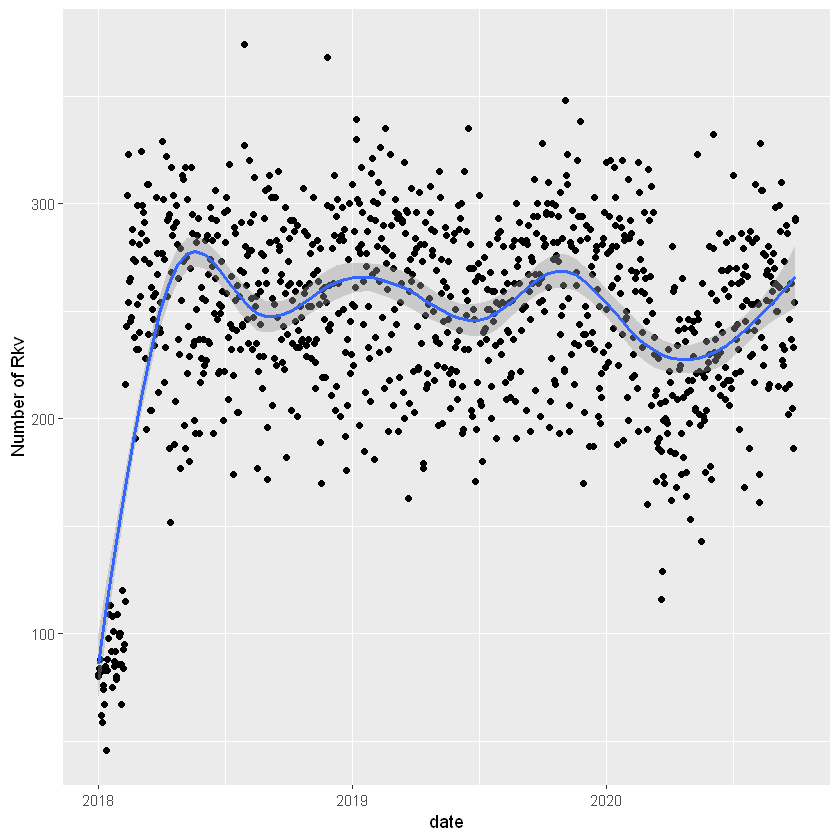

In [44]:
ggplot(data = rkvDate, aes(x = date, y = n_RKV)) +
ylab("Number of Rkv") +
geom_point() +

# arguments are the defaults , only added to supress warnings
# gam = generalized additive model // formula ?? don't know
geom_smooth( method = "gam", formula = y ~ s(x, bs = "cs")) 

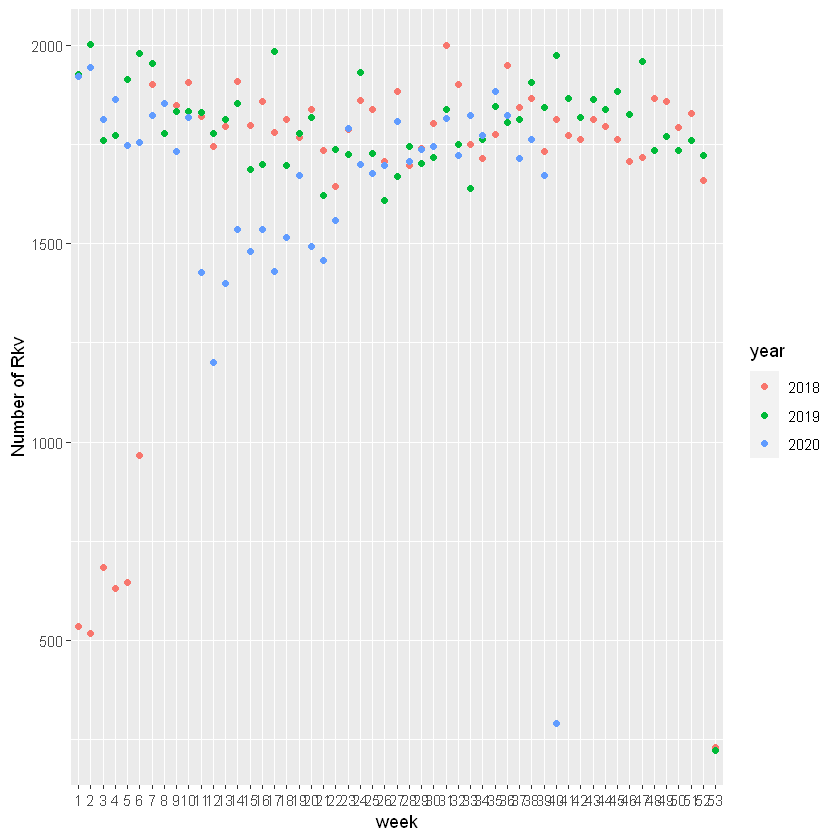

In [45]:
ggplot(data = rkvWeek,  aes(x = week, y = n_RKV, color = year)) +
ylab("Number of Rkv") +
geom_point()

It is possible to see in the two graphs above that early in 2018 the first few weeks have a very low number of RKV. We are not sure why this is the case but are speculating that some mistakes in the processes of acquiring the dataset have happened. The processes have been to export the data from a database to an excel spreadsheet, then to removing sensitive data and converting the data to a CSV file, this process could have influenced the data in these weeks. A second export from the database in the two first months of 2018 would help to validate if the data in this period is correct but haven't been possible during to time constraint. <br>
In the second graph with series for each year, it can be noted that the last point of each of the series ends in a point with a very low number of RKV. This low number of RKV is most likely during the last week being less than 7 days. <br>
An interesting observation is that the effect of Covid-19 can be seen in the two graphs. In the spring of 2020 more preciously the date of "2020-03-11" (week 11) Denmark closed down during to Covid-19, if we take a look at the first graph it is possible to spot a stronger downswing in the nearly 2020 compared to the two previous years, and on the second graph it can be seen that the number of RKV drops sharply in week 11 and 12 then slowly raises over time afterward. 

Since the two plots have many points and are a bit busy with the large variation in the number of RKV, it is hard to extract more detailed knowledge than what was mentioned above. To extract a bit more knowledge two models have been applied. A model to decompose the dataset and a model to forecast the future base on the dataset.

## Decomposing number of RKV over time

To decompose the dataset we first have to make it into a time-series, then two possible functions are available to us. One is the decompose() function that uses a moving average, the other is the stl() function that uses a locally estimated scatterplot smoothing. Below we have decided only to include only the model that uses the locally estimated scatterplot smoothing, since it has the best results. Afterward, the decomposition from the stl() function is used to make a forecast of the future number of RKV over time. In the end, the decomposition and forecasting are repeated with a limited dataset to exclude what is assumed to be abnormal behavior.

In [46]:
startDate = "2018-01-01"
ts(rkvDate$n_RKV, 
   freq=365.25, 
   start=decimal_date(ymd(startDate))
  ) %>%
stl(s.window = "periodic") -> rkv_decomposition

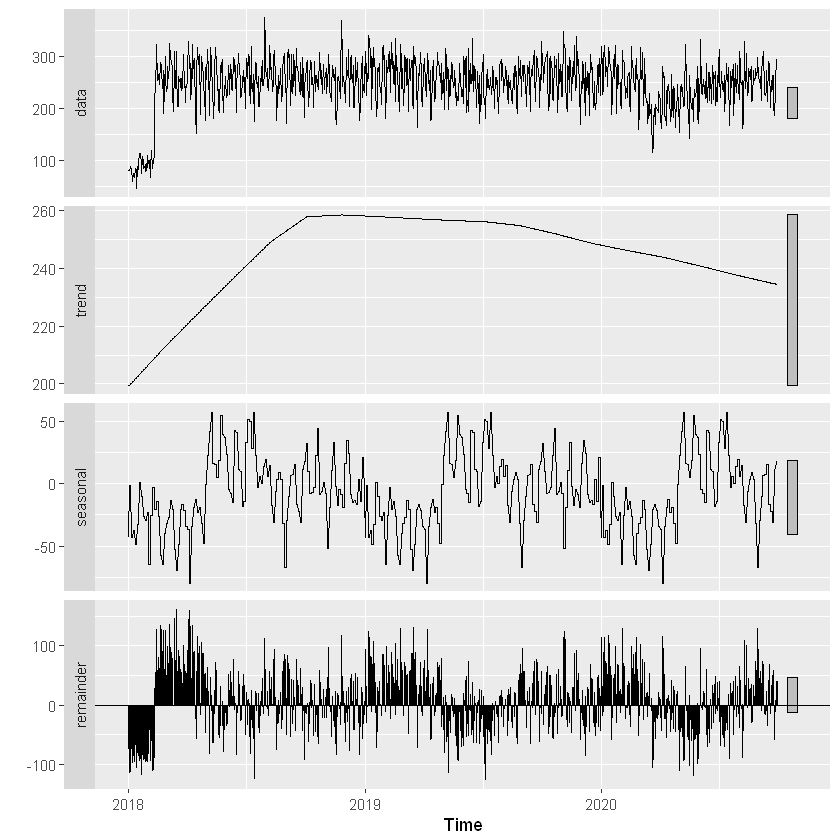

In [47]:
rkv_decomposition %>%
autoplot()

In the decomposition plot above there are a few things to see, but the first few weeks of the dataset look oddly low, and the first half of the year 2020 is affected by Covid-19. To get a better presentation of a "normal" year these two parts of the dataset are excluded in the plots below.

In [48]:
startDate = "2018-03-01"
endDate = "2020-03-01"

modRkvDate <- rkvDate %>%
filter(startDate <= date & date <= endDate)

ts(modRkvDate$n_RKV, 
   freq=365.25, 
   start=decimal_date(ymd(startDate))
  ) %>%
stl(s.window = "periodic") -> modrkv_decomposition

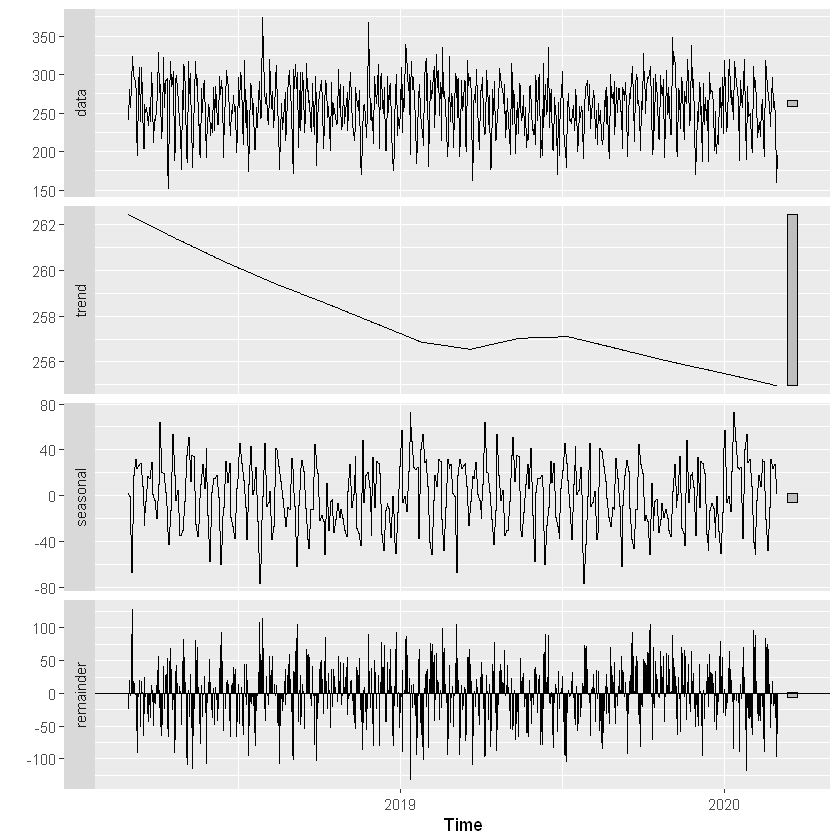

In [49]:
modrkv_decomposition %>%
autoplot()

In the decomposition plot above, the trend doesn't change much but is in a slight decline. In the seasonal component, it looks like there is some regularity in the increases and decreases in what could look like a weekly or monthly cycle. At the same time, it looks like two more stable periods are present around what would be the fall and Christmas vacations. This could potentially be explored further by diving into the seasonal component.

Now let's try to extend this model above to predict how the future will look. To do this we use the forecast package that comes with a function with the same name. Parsing the decomposition to the forecast function produces a model we can plot, see below.

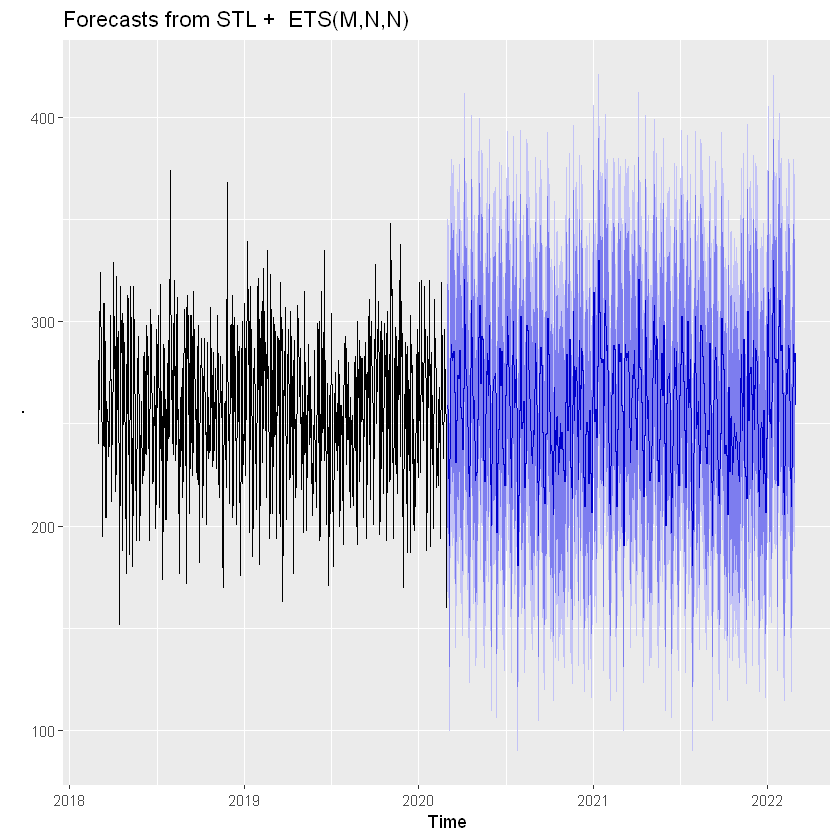

In [50]:
modrkv_decomposition %>%
forecast() %>%
autoplot()

Looking at the forecast above, it looks like not much is changing if we leave out the special circumstances of Covid-19. At the same time, the confidential interval follows the past well and is of course a little wider since it is impossible to be completely certain.

# Conclusion


The business goal of this notebook is to identify possible options to reduce cost, free up resources, and/or to reduce the workload on KBA staff. First, we took a look at which tests were the most frequent and how the expenditure for the tests was distributed. This identified the EKG and INR tests to be rather costly compared to other tests.

Diving deeper into the EKG test, it was found that the Cardio department (hjerte afdeling) had an expense of around 675.000 DKK per year for KBA and an expense of over 3 million DKK per year across all three departments included in the dataset. Two suggestions were raised based on these findings, number one, to let the Cardio department (hjerte afdeling) handle all EKGs and freeing up the workload on KBA. Number two, to move the EKG related work outside KBA to another department or a new sub-department.

When exploring the INR test, it was found that most results were in the normal range of the test. If defining the normal range as [0.8 to 1.2] it was argued that 84.7% of the results were inside the normal range. A suggestion to remove INR as a default test for new patients was proposed in favor of replacing it with a sample with no tests where INR could be reordered if the need should arise.

Afterward, some exploration into the number of RKV was done. The idea was to try to identify some patterns that could be used to increase or decrease KBA staff as the number of RKV changed with the pattern. By decomposing the dataset, it was found that there was some degree of seasonal variance that could be planned for, but we suspected the decomposition was influenced a lot by what looked like outliers in the first few weeks of 2018, and by the atypical Covid-19 pandemic. After excluding the periods we suspected to have a misleading influence, the time-series was again decomposed. The resulting seasonal variance does not have an overall pattern as the first did but looks like it has some more frequent patterns which could be explored further. Especially it is possible to spot two periods in the 4th quarter of each year, where the variance is smaller compared to the rest of the year, this is probably because of the Fall and Christmas vacations. When looking at the forecast, the pattern looks like it is repeating without much change. The forecast also predicts that the two periods with low variance should also be present in the future which could be worth checking upon. Studying the seasonal variance further could be of use for the overall business goal since it can be seen that a pattern is probably present which oscillates typical between +/- 40 RKV per day, ruffly translating into the workload of +/-1 staff member per day.

<b>Conclusion: </b> We can thereby conclude that the analysis of the EKG and INR tests resulted in suggestions that could help solve the business problems but it will be a decision for the management to choose if some or all of the suggestions should be implemented or not. The analysis of the number of RKV resulted in some interesting insights but did not result in anything concrete, but applying decomposition and forecasting have given a hint to where possible solutions might be to the overall business problems.

# Discussion on Big Data and Storage

While working with big data there are some major concerns about storage. Some of the most noticeable aspects are capacity, speed, and availability. To store a big amount of data, the storage solution should be able to contain the data and preferably be able to grow together with the data for some time at least. If this is reflected on KBA the size of the data is rather big compared to the tools used to work with the data. To analyses data from the production environment, Microsoft Office Excel is used at KBA. Working with this size of a dataset in excel has been impractical since some operations simply consumed too much memory to be performed. At the same time, the speed was not good, replacing the sensitive CPR numbers with a fictional ID was a process that took the better part of a day. Creating the table to map each CPR number to a fictional ID was quick, but populating the new fictional ID column depending on the CPR number column took a long time, which had to be repeated for each excel spreadsheet. This example is probably mostly an example of a poor tool for the given task since the performed increased drastically when the combined spreadsheets were processed in R. Some tools take advantage of optimizations that are implemented in the storage for some of the tasks, which points to the importance of the speed of the storage medium to reduce the overall processing time. At KBA the availability of the data is essential to the efficiency of the business, if the automation is down for one reason or another the efficiency drops from 100s of tests to 10s of tests sometimes even less per hour. In the summer of 2020, the storage server supporting KBA needed to be replaced and for more than two weeks the performance of the storage was severely impacted while copying to the new replacement storage. The performance impact resulted in failure when samples from outside clinics arrived and the work-load peaked.       

Reflecting on the business and the case it is clear that big data and storage are of great importance. For the production in the business, speed and availability are of great concern, where capacity is mostly a concern to the supporting IT department. For the case, speed and capacity would be of greater concern since it directly impacts the ability to analyze the data, but is probably mostly caused by inefficient tools. For the case it would have been faster if it was possible to have direct access to read from the database to extract the dataset compared to using the laboratory management system BCC, reducing the importance of speed. If it was possible to mutate the CPR number to a fictional ID directly while exporting the data, or having access to more efficient tools than Excel to mutate the CPR number, the capacity concern would also be reduced.

# Legality and ethics

The dataset processed in this notebook is acquired from a danish hospital in agreement with the department producing and maintaining the data. Some issues arose during the nature of the data, philosophically the data both belong to the patients whose blood markers it describe, but also to the department where it clearly describes the work involved, which tests that was performed, how many, and so on. By having this nature where the point of view can determine the perception of who the data belong to, it is important to realize and think about the greyscales that apply to this dataset. If the dataset is summarized to x number of tests per month, it is clear that the dataset is closer to the department, but summarizing the frequency of RKV for a given patient, or the result of a test over time would be a lot closer to personal information. Ethically it could be argued that the data should only be used for the betterment of the individual patient. Reducing cost does not directly attend this perspective, but from a wider view, it can be said that reducing cost allow for larger-scale improvements in the health sectors, leaving more capacity for additional patients, medically expensive patients, and possibly fewer taxes, benefitting the collective society but in extension also the individual patient.

Legally the dataset contains personal information that is protected by the General Data Protection Regulation (GDPR) by being health care data, no matter what can be argued in an ethical perceptive. The data is collected for health care use in compliance with GDPR as a tool for the treatment of individual patients. The long-term storage of the data still has a purpose for the patient since previous data sometimes has a significate role in diagnosing the patient.

The dataset or any products should therefore be anonymized before being processed or released outside the hospital. Original the dataset included highly sensitive information in the form of CPR-numbers which have been replaced with fictitious IDs. After studying GDPR a bit further, it was realized that any data that could lead back to a person should be anonymized to be compliant with the GDPR. Since the PMB and RKV number can be used in some of the hospital's systems to identify a person. It was decided to censor the numbers by replacing outputs with the text "anonymize" and the dataset was destroyed afterward. If further work was needed the PMB and RKV numbers could have been anonymized in the same way as the CPR-numbers. While reflecting a bit on the requirement to never being able to track back to a person raises some challenges, if a blood marker like INR is taken into account, the very pattern over time could potentially be used to track back to patients if enough data from the hospital is accessible as long as the order of tests is chronological, which theoretical could mean that anything that could give insight should be scrambled.

In [51]:
Udgift %>%
distinct(Kvnt.nr., .keep_all= TRUE) %>%
head(20) %>%
select(Navn, Total) %>%
mutate(avgYear = Total/(2*12+9)*12) -> avgYear

avgYear

Navn,Total,avgYear
Elektrokardiografi [EKG12];Pt,8227662,2991877.1
Koagulationsfaktor II+VII+X [INR];P,3161018,1149461.1
Kalium;P,1638882,595957.1
Kreatinin;P,1624000,590545.5
Natrium;P,1621550,589654.5
Hæmoglobin;B,1529374,556136.0
Leukocytter;B,1515374,551045.1
C-reaktivt protein [CRP];P,1508346,548489.5
Albumin;P,1336454,485983.3
Trombocytter;B,1243368,452133.8


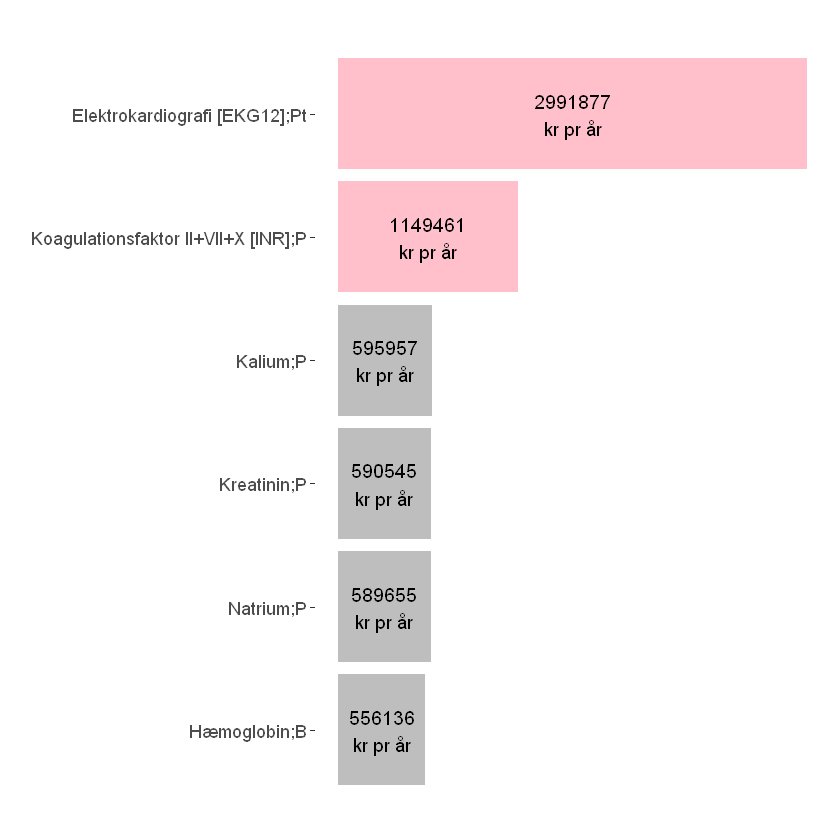

In [52]:
ggplot(data = head(avgYear,6), aes(x = reorder(Navn, avgYear), y = avgYear, label = paste(sprintf("%.0f", avgYear), "kr pr år", sep="\n"))) + 
geom_col(fill="grey") +  
geom_col(data = head(avgYear,2), fill="pink") +  

labs(title="", x = "", y = "") +    
coord_flip() +
geom_text(size = 4, position = position_stack(vjust = 0.5)) +
scale_y_continuous(breaks = seq(0, 300000, 50000))  +
  theme(panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        ,axis.text.x = element_blank()
        ,panel.background = element_blank()
        ,axis.ticks.x = element_blank()
        ,axis.text = element_text(size=11)
       )

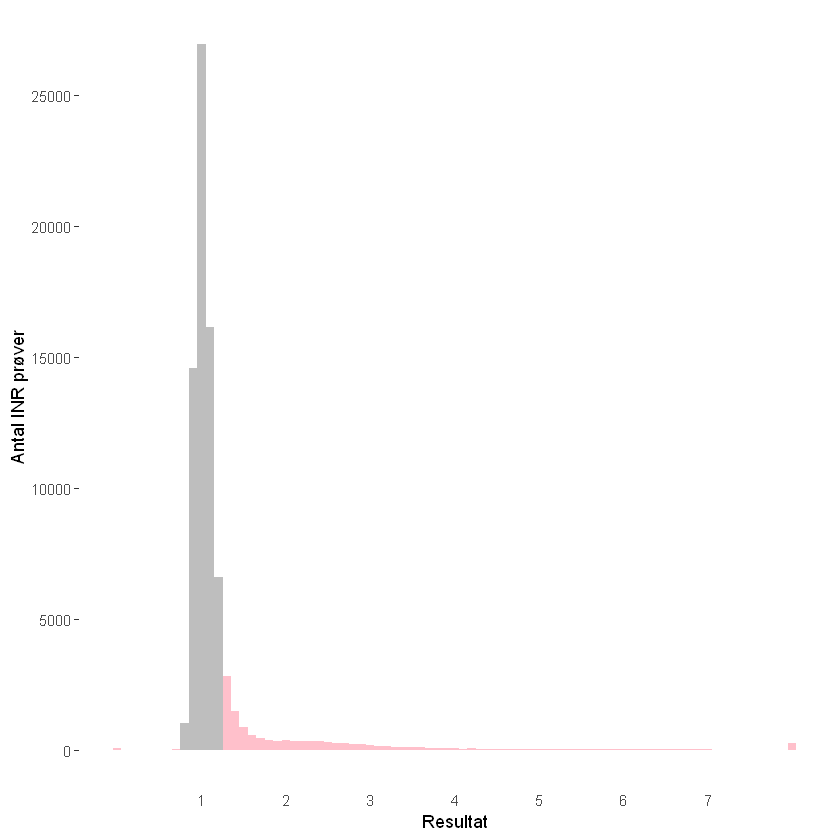

In [53]:
ggplot(inr, aes(Resultat)) +
geom_histogram(binwidth=0.1, stat="bin", fill = "pink") +
geom_histogram(data = inr %>% filter(lower_ref <= Resultat & Resultat <= upper_ref), binwidth=0.1, stat="bin", fill = "grey") +
scale_x_continuous(breaks = seq(1, 7, by= 1)) +     # set scale of the x axis to seq(from, to, by)
 
scale_y_continuous(breaks = seq(0, 30000, by= 5000)) +
ylab("Antal INR prøver") +
theme(panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        ,panel.background = element_blank()
        ,axis.ticks.x = element_blank()
       )

In [54]:
inr %>%
count()

n
77098


In [55]:
inr %>%
filter(lower_ref <= Resultat & Resultat <= upper_ref) %>%
count()

n
65320


In [56]:
Udgift %>%
distinct(Kvnt.nr., .keep_all= TRUE) %>%
head(20) %>%
select(Navn, Total) %>%
mutate(avgYear = Total/(2*12+9)*12) -> avgYear

avgYear

Navn,Total,avgYear
Elektrokardiografi [EKG12];Pt,8227662,2991877.1
Koagulationsfaktor II+VII+X [INR];P,3161018,1149461.1
Kalium;P,1638882,595957.1
Kreatinin;P,1624000,590545.5
Natrium;P,1621550,589654.5
Hæmoglobin;B,1529374,556136.0
Leukocytter;B,1515374,551045.1
C-reaktivt protein [CRP];P,1508346,548489.5
Albumin;P,1336454,485983.3
Trombocytter;B,1243368,452133.8


In [57]:
rawdata %>%
filter(Kvnt.nr. == 5219 & (Resultat != "Aflyst" | Resultat != "aflyst")) %>%
group_by(Rekvirent) %>%
tally(name = "antal") %>% 
mutate(yearlyNumber = antal * 12 / (2*12+9)) -> allEkg 

allEkg



Rekvirent,antal,yearlyNumber
Akut 1.Sal,24519,8916.000
Akut Stue,38542,14015.273
Hjerte Afdeling,18401,6691.273


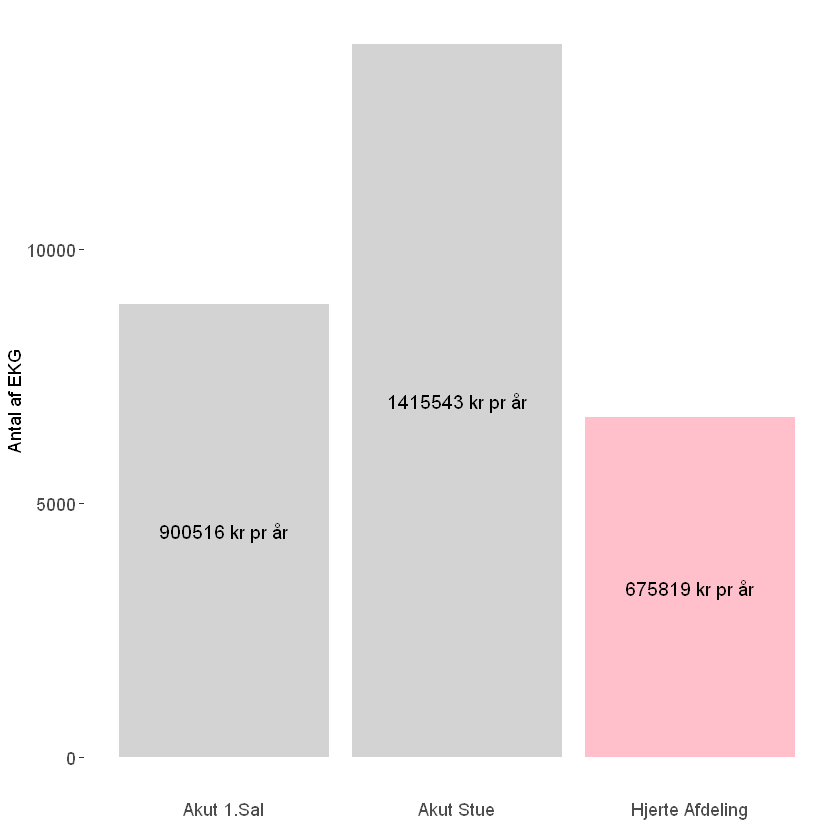

In [58]:
ggplot(data = allEkg, mapping = aes(x = Rekvirent, y = yearlyNumber, label = paste(sprintf("%.0f", yearlyNumber * ekgPrice), "kr pr år", sep=" ") )) + 
geom_col(fill = "lightgrey") + 
geom_col(data = allEkg %>% filter(Rekvirent == "Hjerte Afdeling"), fill = "pink") + 
geom_text(size = 4, position = position_stack(vjust = 0.5)) +

labs(x = "", y = "Antal af EKG") +  
scale_y_continuous(breaks = seq(0, 20000, by= 5000)) +
             
theme(panel.grid.major = element_blank()
    ,panel.grid.minor = element_blank()
    ,panel.background = element_blank()
    ,axis.ticks.x = element_blank()
    ,axis.text = element_text(size=11)
       )